## Матрица и кластеризация

In [1]:
import re
import numpy as np
import pandas as pd
import scipy.cluster.hierarchy as hcluster
import matplotlib.pyplot as plt
import networkx as nx
import itertools
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer
from pymorphy2 import MorphAnalyzer
from tqdm.notebook import tqdm

In [2]:
morph = MorphAnalyzer()
fr_lemmatizer = FrenchLefffLemmatizer()
lemmatizer = WordNetLemmatizer()

In [3]:
words_ru = ["хороший", "прекрасный", "приятный", "классный", "великолепный", "плохой", "ужасный",
            "отвратительный", "чудовищный"]

In [4]:
with open ("files/words_en.txt", "r", encoding="utf-8") as f:
    words_en = [word.rstrip() for word in f.readlines()]

In [5]:
with open ("files/words_fr.txt", "r", encoding="utf-8") as f:
    words_fr = [word.rstrip() for word in f.readlines()]

**Маркируем слова каждого языка**

In [6]:
for i in range(len(words_ru)):
    words_ru[i] = words_ru[i] + "_ru"

In [7]:
for i in range(len(words_en)):
    words_en[i] = words_en[i] + "_en"

In [8]:
for i in range(len(words_fr)):
    words_fr[i] = words_fr[i] + "_fr"

**Достаем контексты**

In [9]:
with open("files/text_en_test.txt", "r", encoding="utf-8") as f:
    text_en_new = f.readlines()

In [10]:
with open("files/text_fr_test.txt", "r", encoding="utf-8") as f:
    text_fr_new = f.readlines()

In [11]:
for i in range(len(text_en_new)):
    if text_en_new[i].endswith("\n"):
        continue
    else:
        text_en_new[i] = text_en_new[i] + "\n"
        
for i in range(len(text_fr_new)):
    if text_fr_new[i].endswith("\n"):
        continue
    else:
        text_fr_new[i] = text_fr_new[i] + "\n"

In [12]:
re_tes = re.compile("[а-яА-Я]*")

In [13]:
contexts = []
for sent in text_en_new:
    if re.findall(re_tes, sent)[0] != '':
        contexts.append(sent)
print("Контекстов с англ: " + str(len(contexts)))

Контекстов с англ: 345


In [14]:
contexts_2 = []
for sent in text_fr_new:
    if re.findall(re_tes, sent)[0] != '':
        contexts_2.append(sent)
print("Контекстов с фр: " + str(len(contexts_2)))

Контекстов с фр: 182


In [15]:
mutual_contexts = []
for sent in contexts:
    if sent in contexts_2:
        mutual_contexts.append(sent)
print("Общих контекстов: " + str(len(mutual_contexts)))

Общих контекстов: 125


In [16]:
all_words = words_ru + words_en + words_fr
print("Всего слов: " + str(len(all_words)))

Всего слов: 59


In [17]:
word_indices = {k: v+1 for v, k in enumerate(all_words)}

**Создаем и заполняем матрицу**

In [18]:
table = np.zeros([len(mutual_contexts)+1, len(all_words)+1], dtype=object)
print(table.shape)
table[0][0] = "NA"

(126, 60)


In [19]:
for i in range(table.shape[0]-1):
    table[i+1][0] = mutual_contexts[i]
for k in range(table.shape[1]-1):
    table[0][k+1] = all_words[k]

In [20]:
for i in range(table.shape[0]):
    if table[i][0] in text_en_new:
        index = text_en_new.index(table[i][0]) - 1
        word = lemmatizer.lemmatize(text_en_new[index].split()[0].lower(), pos=wordnet.ADJ)
        word = word + "_en"
        table[i][word_indices[word]] = 1

In [21]:
for i in range(table.shape[0]):
    if table[i][0] in text_fr_new:
        index = text_fr_new.index(table[i][0]) + 1
        word = fr_lemmatizer.lemmatize(text_fr_new[index].split()[0].lower(), "a")
        word = word + "_fr"
        table[i][word_indices[word]] = 1

In [22]:
for i in range(table.shape[0]):
    if table[i][0] in mutual_contexts:
        index = i - 1
        possible_parsing = []
        word = mutual_contexts[index].split()[0].lower()
        for parse in morph.parse(word):
            possible_parsing.append(parse.normal_form + "_ru")
            
        for possible_pars in possible_parsing:
            if possible_pars in word_indices:
                table[i][word_indices[possible_pars]] = 1
                break

In [23]:
data = pd.DataFrame(data=table[1:,1:],
                    index=table[1:,0],
                    columns=table[0,1:])

In [24]:
data.head()

,хороший_ru,прекрасный_ru,приятный_ru,классный_ru,великолепный_ru,плохой_ru,ужасный_ru,отвратительный_ru,чудовищный_ru,short_en,...,géant_fr,excellent_fr,horrible_fr,propre_fr,beau_fr,premier_fr,terrible_fr,monstrueux_fr,nouveau_fr,impossible_fr
"отвратительном Это подтверждал и Снегг, который неизменно пребывал в привычном для него отвратительном настроении.\n",0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
хорошего А сейчас – хорошего вам дня.\n,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
хороший Это был хороший сон.\n,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
"ужасный Взяв кухонные ножницы, она обкорнала его почти налысо, оставив лишь маленький хохолок на лбу, чтобы, как она выразилась, «спрятать этот ужасный шрам».\n",0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
"хорошим Впоследствии Гарри говорил себе, что начало дня было чересчур хорошим для того, чтобы таким же оказался и его конец.\n",1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [25]:
# data.to_csv(r'data.tsv', sep= "\t" ,encoding='utf-8-sig')

## Кластеризация

In [26]:
Z = hcluster.linkage(data)

In [27]:
clusters = hcluster.fcluster(Z, t = 1)
print('Estimated number of clusters: %d' % len(set(clusters)))

Estimated number of clusters: 28


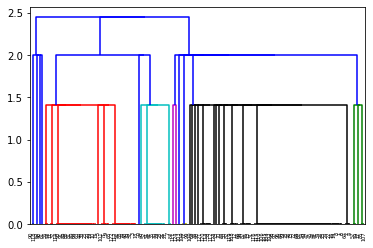

In [28]:
plt.figure()
dn = hcluster.dendrogram(Z)
plt.show()

In [29]:
clusters_hier = [[] for i in range(len(set(clusters)))]
for i, j in enumerate(clusters):
    clusters_hier[j-1].append(mutual_contexts[i])

In [30]:
clus_ex_two = 0
for i, clus in enumerate(clusters_hier):
    if len(clus) >= 2:
        clus_ex_two+=1
        print("Кластер № ", i+1)
        for cl in clus:
            ind_en = text_en_new.index(cl)
            ind_fr = text_fr_new.index(cl)
            print(cl, text_en_new[ind_en-1], text_fr_new[ind_fr+1])
        print("\n")

Кластер №  1
чудовищный — А где Билл, Чарли и Пе-Пе-Перси? – сказал Джордж, безуспешно пытаясь подавить чудовищный зевок.
 huge ‘Where’re Bill and Charlie and Per–Per–Percy?’ said George, failing to stifle a huge yawn.
 impossible — Où sont Bill, Charlie et Pe-e-e-e-e-e-ercy? demanda George dans un très long bâillement qu’il lui fut impossible de retenir.

чудовищную Ничего не ответив, Гарри снова повернулся посмотреть на чудовищную фигуру великана, спящего перед ними на лужайке.
 gigantic Harry said nothing, but turned to look back at the gigantic form lying asleep on the ground in front of them.
 gigantesque Sans dire un mot, Harry se retourna vers la silhouette gigantesque endormie sur le sol.

чудовищной Тем временем на глазах у Гарри и Гермионы великан подымался с земли — она задрожала, когда он оперся на нее чудовищной дланью, помогая себе встать на колени.
 enormous In front of Harry and Hermione, meanwhile, the gigantic Grawp was rising from the ground, which shuddered as he pl

In [31]:
print("Кластеров с 2 и более контекстами: " + str(clus_ex_two))

Кластеров с 2 и более контекстами: 17


In [32]:
for i in range(table.shape[0]-1):
    if list(table[i+1]).count(1) != 3:
        print("wrong")

## K means

In [33]:
from sklearn.cluster import KMeans

In [34]:
kmeans = KMeans(n_clusters=8).fit(data)
clusters = kmeans.labels_

In [35]:
clusters_hier = [[] for i in range(len(set(clusters)))]
for i, j in enumerate(clusters):
    clusters_hier[j-1].append(mutual_contexts[i])

In [36]:
for i, clus in enumerate(clusters_hier):
    print("Кластер № ", i+1)
    for cl in clus:
        ind_en = text_en_new.index(cl)
        ind_fr = text_fr_new.index(cl)
        print(cl)#, text_en_new[ind_en-1], text_fr_new[ind_fr+1])
    print("\n")

Кластер №  1
хорошего А сейчас – хорошего вам дня.

хороший Это был хороший сон.

хорошим Впоследствии Гарри говорил себе, что начало дня было чересчур хорошим для того, чтобы таким же оказался и его конец.

хорошем Дядя пребывал в очень хорошем настроении.

Хороший – Хороший вопрос, Гарри.

лучше — Даже лучше, что палочка не сработала.

хорошего Он был готов поспорить на что угодно, даже на свою «Молнию», — ничего хорошего Трелони не увидит.

хороший — Очень хороший учитель, — одобрила Гермиона.

хорошего — Вероятно, потому, что днем они почти не покидают кухни, — ответил Ник — Они выходят только ночью, для уборки... присмотреть за факелами, то да се... Я хочу сказать, вы и не должны их видеть... Это ведь и есть признак хорошего домашнего эльфа — что вы его не замечаете, не так ли?

хорошая — Но я подумал, что хорошая встряска...

хороший Победив желание дать бывшему другу хороший подзатыльник, он наконец добрался до стола и сел.

хорошей После смерти его сына стали жалеть, и многие с

## Граф

In [37]:
all_pairs = []
for pair in itertools.combinations(all_words, r=2):
    all_pairs.append(pair)
translate_dict = {}
for pair in all_pairs:
    translate_dict[pair] = 0.0

In [38]:
for i in range(table.shape[0]-1):
    index = 0
    needed_indices = []
    for k in list(table[i+1]):
        if k == 1:
            needed_indices.append(index)
        index += 1
    words_in_cont = []
    for ind in needed_indices:
        words_in_cont.append(table[0][ind])
    for pair in itertools.combinations(words_in_cont, r=2):
        translate_dict[pair] += 1

In [39]:
# for pair, value in translate_dict.items():
#     if value > 0:
#         print(pair, value)

In [40]:
G = nx.Graph()
G.add_nodes_from(all_words)
for key, value in translate_dict.items():
    if value != 0:
        G.add_edge(key[0], key[1], weight=value)

In [41]:
print("вершин:", G.number_of_nodes())
print("ребер:", G.number_of_edges())

вершин: 59
ребер: 79


In [42]:
weights = [G[u][v]['weight']/5 for u,v in G.edges()]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


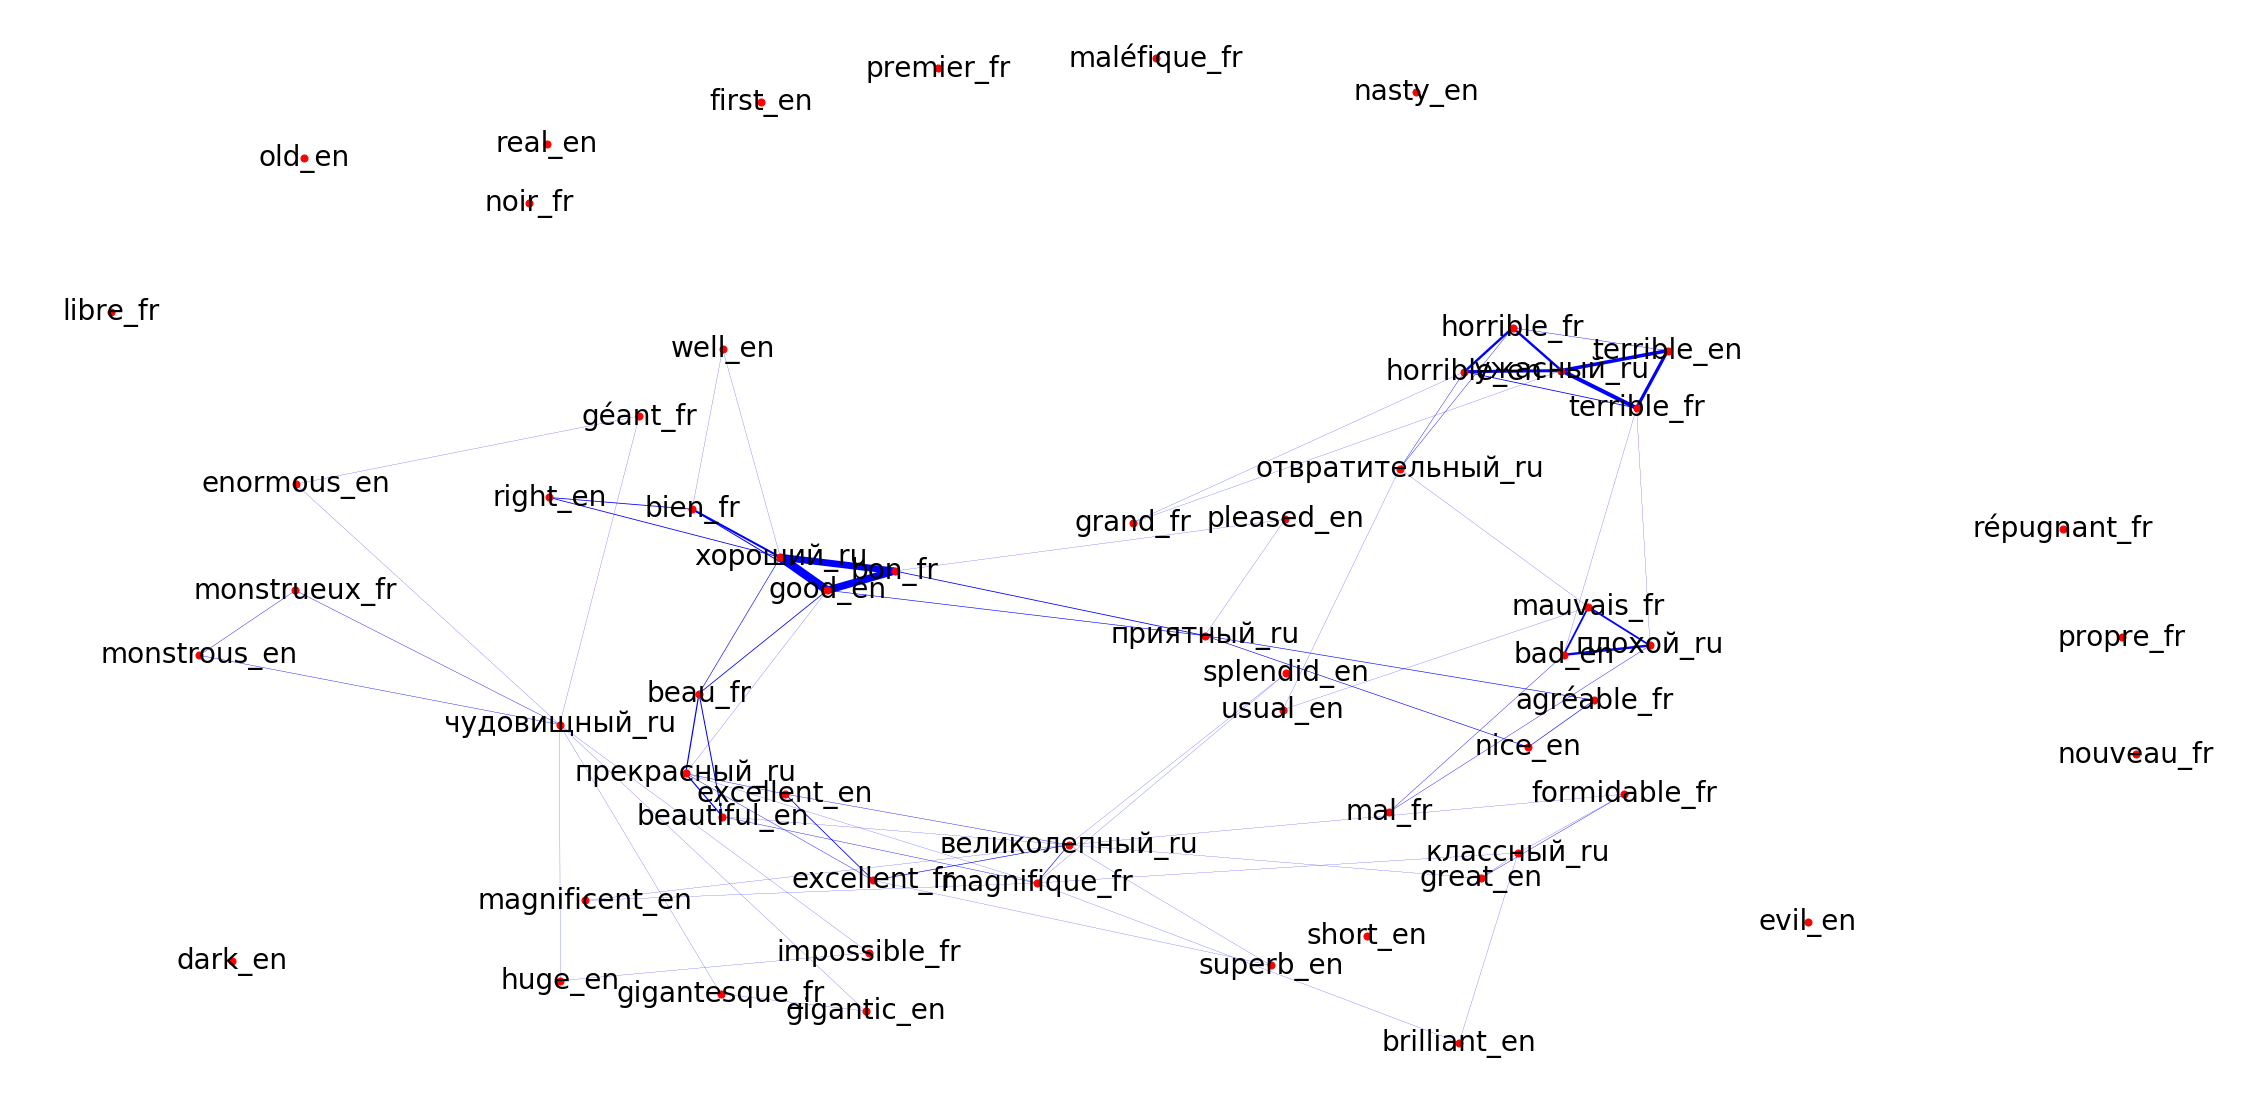

In [43]:
pos=nx.spring_layout(G, k=0.55, seed=17)

plt.figure(figsize=(40,20))
nx.draw_networkx_nodes(G, pos, node_color='red', node_size=50)
nx.draw_networkx_edges(G, pos, edge_color='blue', width=weights)
nx.draw_networkx_labels(G, pos, font_size=28)
plt.axis('off')
# plt.savefig("graph_2.png")
plt.show()